# Assignment 02 - Image Classification

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set()

## 1. Data and Functions

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR100_train = torchvision.datasets.CIFAR100(root='CIFAR100',train=True,download=True,transform=transform)
CIFAR100_val_test = torchvision.datasets.CIFAR100(root='CIFAR100',train=False,download=True,transform=transform)
# converting images to tensors is necessary here, otherwise the data will be unusable

Files already downloaded and verified
Files already downloaded and verified


In [3]:
CIFAR100_val = torch.utils.data.Subset(CIFAR100_val_test, range(5000))
CIFAR100_test = torch.utils.data.Subset(CIFAR100_val_test, range(5000,10000))

In [4]:
batch_size = 64
train_dataloader = DataLoader(CIFAR100_train, shuffle=True, num_workers=0, batch_size=batch_size)
val_dataloader = DataLoader(CIFAR100_val, shuffle=True, num_workers=0, batch_size=batch_size)
test_dataloader = DataLoader(CIFAR100_test, shuffle=True, num_workers=0, batch_size=batch_size)

In [5]:
img = CIFAR100_train[0]  

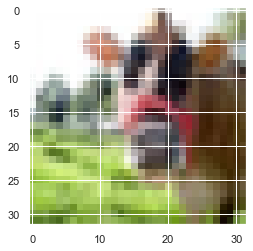

In [6]:
img = img[0] / 2 + 0.5
img_print = img.numpy()
plt.imshow(np.transpose(img_print, (1, 2, 0)))   # imshow requires (M,N,3), so we need to specify axes in np.transpose method
plt.show()

In [7]:
label_list = []
for i in range(len(CIFAR100_train)):
    label_list.append(CIFAR100_train[i][1])

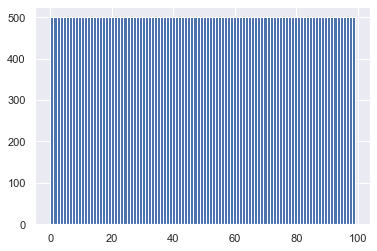

In [8]:
plt.hist(label_list, bins = 100);   # the training data is perfectly balanced

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    num_batches = len(dataloader)     
    model.train()
    train_loss, num_correct_pred = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()   
        
        pred = model(X)
        loss = loss_fn(pred, y)  
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()    
        num_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:      
            loss, current = loss.item(), batch * len(X)  
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    num_correct_pred /= size
    
    return train_loss, num_correct_pred

In [10]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)   
    num_batches = len(dataloader)     
    model.eval()                      
    val_loss, num_correct_pred = 0, 0     
    with torch.no_grad():         
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()   
            num_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches     
    num_correct_pred /= size          
    print(f"Test Error: \n Accuracy: {(100*num_correct_pred):>0.2f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss, num_correct_pred

In [11]:
epoch = 20
def train_eval_pipline(model, optimizer, train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch = epoch):    
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for i in range(epoch):
        print(f'epoch: {i+1}/{epoch}')
        train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)    
        val_loss, val_acc = val(val_dataloader, model, loss_fn)                      
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("Done!")
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [12]:
loss_fn = nn.CrossEntropyLoss()

## 2. Small CNN

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),         
            nn.ReLU(),              
            nn.Conv2d(8, 16, kernel_size=3, padding=1),   
            nn.ReLU(),            
            nn.MaxPool2d(2,2),
            nn.Flatten(),    
            nn.Linear(16*16*16, 512),  
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [14]:
class CNN_batchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),   
            nn.BatchNorm2d(8),            
            nn.ReLU(),              
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),              
            nn.MaxPool2d(2,2),
            nn.Flatten(),    
            nn.Linear(16*16*16, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [15]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),   
            nn.Dropout2d(p=0.2),           
            nn.ReLU(),             
            nn.Conv2d(8, 16, kernel_size=3, padding=1),    
            nn.Dropout2d(p=0.2), 
            nn.ReLU(),              
            nn.MaxPool2d(2,2),
            nn.Flatten(),    
            nn.Linear(16*16*16, 512),  
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [16]:
class CNN_batch_drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),   
            nn.BatchNorm2d(8), 
            nn.Dropout2d(p=0.2),           
            nn.ReLU(),             
            nn.Conv2d(8, 16, kernel_size=3, padding=1),   
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),              
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),    
            nn.Linear(16*16*16, 512),  
            nn.BatchNorm1d(512),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [17]:
cnn = CNN().to(device)
cnn_batchnorm = CNN_batchnorm().to(device)
cnn_dropout = CNN_dropout().to(device)
cnn_batch_drop = CNN_batch_drop().to(device)
model_list = [cnn, cnn_batchnorm, cnn_dropout, cnn_batch_drop]

In [18]:
train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []
for model in model_list:
    # print(model)
    optimizer = optim.Adam(model.parameters(), weight_decay=0.002)
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_eval_pipline(model, optimizer)
    train_loss_log.append(train_loss_list)
    train_acc_log.append(train_acc_list)
    val_loss_log.append(val_loss_list)
    val_acc_log.append(val_acc_list)

epoch: 1/20
loss: 4.607707  [    0/50000]
loss: 4.057685  [ 6400/50000]
loss: 3.474153  [12800/50000]
loss: 3.708353  [19200/50000]
loss: 3.557402  [25600/50000]
loss: 3.299042  [32000/50000]
loss: 3.150592  [38400/50000]
loss: 3.343820  [44800/50000]
Test Error: 
 Accuracy: 21.60%, Avg loss: 3.259603 

epoch: 2/20
loss: 3.088770  [    0/50000]
loss: 3.318894  [ 6400/50000]
loss: 3.182516  [12800/50000]
loss: 3.333484  [19200/50000]
loss: 2.821992  [25600/50000]
loss: 2.698235  [32000/50000]
loss: 3.027875  [38400/50000]
loss: 2.894066  [44800/50000]
Test Error: 
 Accuracy: 27.96%, Avg loss: 2.942798 

epoch: 3/20
loss: 2.789984  [    0/50000]
loss: 2.906166  [ 6400/50000]
loss: 2.867210  [12800/50000]
loss: 2.404643  [19200/50000]
loss: 2.473897  [25600/50000]
loss: 2.810591  [32000/50000]
loss: 2.803221  [38400/50000]
loss: 2.929661  [44800/50000]
Test Error: 
 Accuracy: 29.94%, Avg loss: 2.794865 

epoch: 4/20
loss: 2.269165  [    0/50000]
loss: 2.561809  [ 6400/50000]
loss: 2.17994

(0.0, 5.0)

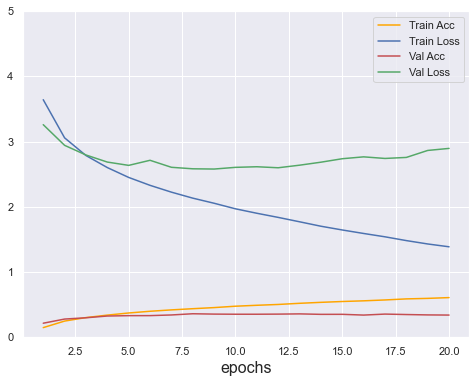

In [19]:
i = 0         # i = 0,1,2,3 to print different figures
sns.set()
plt.figure(figsize=(8,6))
plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_log[i], 'b')
plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_log[i], 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0,5)

## 3. Larger CNN

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),      
            nn.ReLU(),             
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   
            nn.ReLU(),              
            nn.Conv2d(64, 64, kernel_size=3, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    
            nn.ReLU(),              
            nn.Conv2d(128, 128, kernel_size=3, padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),    
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [21]:
class CNN_batchnorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   
            nn.BatchNorm2d(32),               
            nn.ReLU(),             
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),             
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),             
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),    
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 512),  
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [22]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    
            nn.Dropout2d(p=0.2),          
            nn.ReLU(),             
            nn.Conv2d(32, 32, kernel_size=3, padding=1),   
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    
            nn.Dropout2d(p=0.2),
            nn.ReLU(),              
            nn.Conv2d(64, 64, kernel_size=3, padding=1),    
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.Dropout2d(p=0.2),
            nn.ReLU(),             
            nn.Conv2d(128, 128, kernel_size=3, padding=1),    
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),    
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Linear(1024, 512),  
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [23]:
class CNN_batch_drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),              
            nn.Conv2d(32, 32, kernel_size=3, padding=1),    
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),             
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),    
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 100)
            )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [24]:
cnn = CNN().to(device)
cnn_batchnorm = CNN_batchnorm().to(device)
cnn_dropout = CNN_dropout().to(device)
cnn_batch_drop = CNN_batch_drop().to(device)
model_list = [cnn, cnn_batchnorm, cnn_dropout, cnn_batch_drop]

In [25]:
train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []
for model in model_list:
    # print(model)
    optimizer = optim.Adam(model.parameters(), weight_decay=0.002)
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_eval_pipline(model, optimizer)
    train_loss_log.append(train_loss_list)
    train_acc_log.append(train_acc_list)
    val_loss_log.append(val_loss_list)
    val_acc_log.append(val_acc_list)

epoch: 1/20
loss: 4.609509  [    0/50000]
loss: 4.606619  [ 6400/50000]
loss: 4.601771  [12800/50000]
loss: 4.602160  [19200/50000]
loss: 4.602941  [25600/50000]
loss: 4.608724  [32000/50000]
loss: 4.607146  [38400/50000]
loss: 4.605770  [44800/50000]
Test Error: 
 Accuracy: 1.00%, Avg loss: 4.605178 

epoch: 2/20
loss: 4.605970  [    0/50000]
loss: 4.603778  [ 6400/50000]
loss: 4.605203  [12800/50000]
loss: 4.609757  [19200/50000]
loss: 4.604903  [25600/50000]
loss: 4.606379  [32000/50000]
loss: 4.604238  [38400/50000]
loss: 4.605453  [44800/50000]
Test Error: 
 Accuracy: 0.88%, Avg loss: 4.605550 

epoch: 3/20
loss: 4.605265  [    0/50000]
loss: 4.607576  [ 6400/50000]
loss: 4.605451  [12800/50000]
loss: 4.606055  [19200/50000]
loss: 4.604052  [25600/50000]
loss: 4.605787  [32000/50000]
loss: 4.604367  [38400/50000]
loss: 4.607018  [44800/50000]
Test Error: 
 Accuracy: 0.92%, Avg loss: 4.605191 

epoch: 4/20
loss: 4.605343  [    0/50000]
loss: 4.605099  [ 6400/50000]
loss: 4.607393  

(0.0, 5.0)

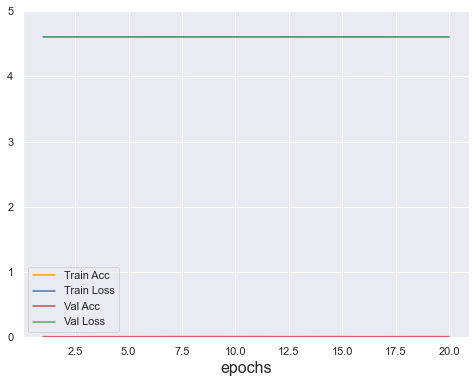

In [26]:
i = 0         # i = 0,1,2,3 to print different figures
sns.set()
plt.figure(figsize=(8,6))
plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_log[i], 'b')
plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_log[i], 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0,5)

## 4. ResNet

In [27]:
# reference: Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.main_layer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(out_channels)),
            ('relu', nn.ReLU()),
            ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(out_channels))
        ]))
        self.skip_layer = nn.Sequential(OrderedDict([]))
        if stride > 1:
            self.skip_layer = nn.Sequential(OrderedDict([
                ('skip_conv', nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)),
                ('skip_bn', nn.BatchNorm2d(out_channels))
            ]))
    
    def forward(self, x):
        Z = x
        for layer in self.main_layer:
            Z = layer(Z)
        skip_Z = x
        for layer in self.skip_layer:
            skip_Z = layer(skip_Z)
        
        return F.relu(Z + skip_Z)    

In [28]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32,32,stride=1),
            ResidualBlock(32,64,stride=2),
            ResidualBlock(64,128,stride=2),
            ResidualBlock(128,128,stride=1),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout1d(p=0.2),
            nn.Linear(512, 100)
        )
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [29]:
resnet = ResNet().to(device)
model_list = [resnet]

In [30]:
train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []
for model in model_list:
    # print(model)
    optimizer = optim.Adam(model.parameters(), weight_decay=0.002)
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_eval_pipline(model, optimizer)
    train_loss_log.append(train_loss_list)
    train_acc_log.append(train_acc_list)
    val_loss_log.append(val_loss_list)
    val_acc_log.append(val_acc_list)

epoch: 1/20
loss: 4.611382  [    0/50000]
loss: 4.284529  [ 6400/50000]
loss: 4.249906  [12800/50000]
loss: 3.816911  [19200/50000]
loss: 3.579865  [25600/50000]
loss: 3.749277  [32000/50000]
loss: 3.819775  [38400/50000]
loss: 3.619813  [44800/50000]
Test Error: 
 Accuracy: 19.36%, Avg loss: 3.347069 

epoch: 2/20
loss: 3.360391  [    0/50000]
loss: 3.229656  [ 6400/50000]
loss: 3.151928  [12800/50000]
loss: 3.833836  [19200/50000]
loss: 3.443697  [25600/50000]
loss: 3.263382  [32000/50000]
loss: 3.222659  [38400/50000]
loss: 3.201962  [44800/50000]
Test Error: 
 Accuracy: 26.24%, Avg loss: 2.965849 

epoch: 3/20
loss: 3.280777  [    0/50000]
loss: 3.305663  [ 6400/50000]
loss: 3.443156  [12800/50000]
loss: 3.260656  [19200/50000]
loss: 2.906157  [25600/50000]
loss: 2.874722  [32000/50000]
loss: 3.065026  [38400/50000]
loss: 2.635321  [44800/50000]
Test Error: 
 Accuracy: 32.54%, Avg loss: 2.704292 

epoch: 4/20
loss: 2.772076  [    0/50000]
loss: 2.946732  [ 6400/50000]
loss: 2.75687

(0.0, 5.0)

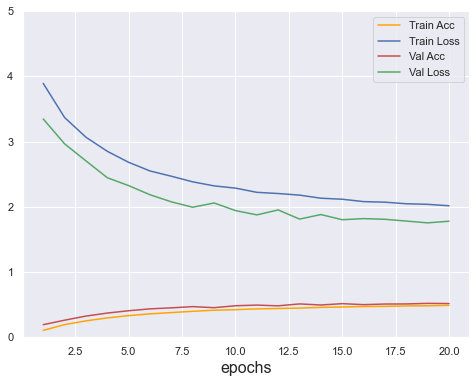

In [31]:
i = 0         # i = 0,1,2,3 to print different figures
sns.set()
plt.figure(figsize=(8,6))
plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_log[i], 'b')
plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_log[i], 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0,5)

In [32]:
correct = 0
total = 0
resnet.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        pred = resnet(X)
        predicted = pred.argmax(axis=1)
        total += y.shape[0]
        correct += (predicted == y).sum().item()
print('Accuracy on the test set is:',correct/total)

Accuracy on the test set is: 0.5194


## 5. Comparison of Large CNN, ResNet, and MLP

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),  
            nn.BatchNorm2d(32),               
            nn.ReLU(),            
            nn.Conv2d(32, 32, kernel_size=3, padding=1),     
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),    
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),    
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),    
            nn.BatchNorm2d(64),
            nn.ReLU(),             
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),    
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),    
            nn.BatchNorm2d(128),
            nn.ReLU(),              
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),   
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout1d(p=0.2),
            nn.Linear(512, 100)
        )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [34]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            ResidualBlock(3,32,stride=2),
            ResidualBlock(32,32,stride=1),
            ResidualBlock(32,64,stride=2),
            ResidualBlock(64,64,stride=1),
            ResidualBlock(64,128,stride=2),
            ResidualBlock(128,128,stride=1),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout1d(p=0.2),
            nn.Linear(512, 100)
        )
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [35]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
        )
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [36]:
cnn = CNN().to(device)
resnet = ResNet().to(device)
mlp = MLP().to(device)
model_list = [cnn,resnet,mlp]
model_name_list = ['Large CNN','ResNet','MLP']

In [37]:
train_loss_log = []
train_acc_log = []
val_loss_log = []
val_acc_log = []
for model in model_list:
    # print(model)
    optimizer = optim.Adam(model.parameters(), weight_decay=0.002)
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_eval_pipline(model, optimizer)
    train_loss_log.append(train_loss_list)
    train_acc_log.append(train_acc_list)
    val_loss_log.append(val_loss_list)
    val_acc_log.append(val_acc_list)

epoch: 1/20
loss: 4.582401  [    0/50000]
loss: 4.333069  [ 6400/50000]
loss: 4.403183  [12800/50000]
loss: 4.116246  [19200/50000]
loss: 4.337037  [25600/50000]
loss: 3.983940  [32000/50000]
loss: 4.026188  [38400/50000]
loss: 3.894936  [44800/50000]
Test Error: 
 Accuracy: 7.06%, Avg loss: 3.975242 

epoch: 2/20
loss: 4.014978  [    0/50000]
loss: 4.136800  [ 6400/50000]
loss: 4.215369  [12800/50000]
loss: 3.883451  [19200/50000]
loss: 3.864337  [25600/50000]
loss: 3.971256  [32000/50000]
loss: 4.062180  [38400/50000]
loss: 4.085300  [44800/50000]
Test Error: 
 Accuracy: 8.92%, Avg loss: 3.907586 

epoch: 3/20
loss: 4.091034  [    0/50000]
loss: 3.774217  [ 6400/50000]
loss: 3.645195  [12800/50000]
loss: 3.958992  [19200/50000]
loss: 3.648272  [25600/50000]
loss: 4.037190  [32000/50000]
loss: 4.048248  [38400/50000]
loss: 3.737868  [44800/50000]
Test Error: 
 Accuracy: 12.94%, Avg loss: 3.652808 

epoch: 4/20
loss: 3.979540  [    0/50000]
loss: 3.779125  [ 6400/50000]
loss: 3.729774 

(0.0, 5.0)

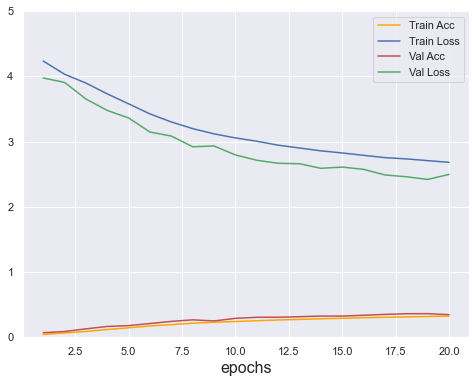

In [38]:
i = 0         # i = 0,1,2,3 to print different figures
sns.set()
plt.figure(figsize=(8,6))
plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_log[i], 'b')
plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_log[i], 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0,5)

In [39]:
for i in range(len(model_list)):
    correct = 0
    total = 0
    model_list[i].eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model_list[i](X)
            predicted = pred.argmax(axis=1)
            total += y.shape[0]
            correct += (predicted == y).sum().item()
    print("{}'s accuracy on the test set is:".format(model_name_list[i]), correct/total)

Large CNN's accuracy on the test set is: 0.353
ResNet's accuracy on the test set is: 0.465
MLP's accuracy on the test set is: 0.2236


## 6. Play with CNN

In [40]:
black_white_layer = nn.Conv2d(3,3,kernel_size=3,bias=False,padding=1) 
blur_layer = nn.Conv2d(3,3,kernel_size=3,bias=False,padding=1) 

In [41]:
black_white_core = torch.tensor([[[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]]],[[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]]],[[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]],[[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]]]])
blur_core = torch.tensor([[[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]]],[[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]]],[[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]],[[0.5,0.8,0.5],[0.8,1.0,0.8],[0.5,0.8,0.5]]]])

In [42]:
black_white_layer.weight = nn.Parameter(black_white_core)
blur_layer.weight = nn.Parameter(blur_core)

In [43]:
img_input = CIFAR100_train[0][0] / 2 + 0.5

In [44]:
black_white = black_white_layer(img_input)
blur = blur_layer(img_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


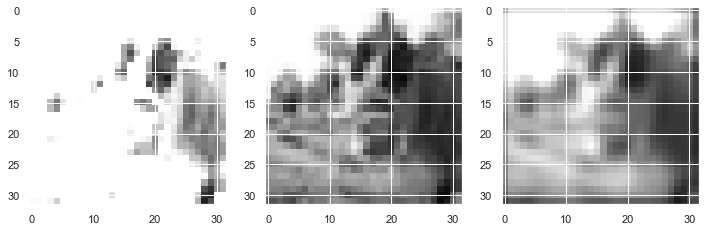

In [53]:
fig_sub,plots = plt.subplots(1,3,figsize=(12,4))
plots[0].imshow(np.transpose((black_white).detach().numpy(), (1, 2, 0))) 
plots[1].imshow(np.transpose((black_white/3).detach().numpy(), (1, 2, 0))) 
plots[2].imshow(np.transpose((blur/15).detach().numpy(), (1, 2, 0))) 

In [46]:
CIFAR100_train = torchvision.datasets.CIFAR100(root='CIFAR100',train=True,download=True,transform=transforms.ToTensor())
CIFAR100_val_test = torchvision.datasets.CIFAR100(root='CIFAR100',train=False,download=True,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [47]:
batch_size = 64
train_dataloader = DataLoader(CIFAR100_train, shuffle=True, num_workers=0, batch_size=batch_size)
val_dataloader = DataLoader(CIFAR100_val, shuffle=True, num_workers=0, batch_size=batch_size)
test_dataloader = DataLoader(CIFAR100_test, shuffle=True, num_workers=0, batch_size=batch_size)

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),           
            nn.ReLU(),            
            nn.Conv2d(16, 16, kernel_size=5, padding=2),        
            nn.ReLU(),             
            nn.MaxPool2d(2,2),
            nn.Flatten(),    
            nn.Linear(4096, 512),  
            nn.ReLU(),
            nn.Linear(512, 100),
        )
    
    def forward(self, x):
        logits = self.stack(x)
        return logits

In [49]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.002)

In [50]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_eval_pipline(model, optimizer)#, train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch = epoch)

epoch: 1/20
loss: 4.607705  [    0/50000]
loss: 4.053129  [ 6400/50000]
loss: 4.101957  [12800/50000]
loss: 3.648286  [19200/50000]
loss: 3.532486  [25600/50000]
loss: 3.450978  [32000/50000]
loss: 3.011442  [38400/50000]
loss: 3.681987  [44800/50000]
Test Error: 
 Accuracy: 22.00%, Avg loss: 3.241813 

epoch: 2/20
loss: 3.238076  [    0/50000]
loss: 3.479776  [ 6400/50000]
loss: 2.935199  [12800/50000]
loss: 2.659300  [19200/50000]
loss: 2.782674  [25600/50000]
loss: 2.924260  [32000/50000]
loss: 3.064341  [38400/50000]
loss: 3.114896  [44800/50000]
Test Error: 
 Accuracy: 27.62%, Avg loss: 2.935415 

epoch: 3/20
loss: 2.787511  [    0/50000]
loss: 2.697279  [ 6400/50000]
loss: 3.062169  [12800/50000]
loss: 2.692116  [19200/50000]
loss: 2.709245  [25600/50000]
loss: 2.473659  [32000/50000]
loss: 2.468751  [38400/50000]
loss: 3.153092  [44800/50000]
Test Error: 
 Accuracy: 30.60%, Avg loss: 2.804216 

epoch: 4/20
loss: 2.275077  [    0/50000]
loss: 2.547446  [ 6400/50000]
loss: 2.12033

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

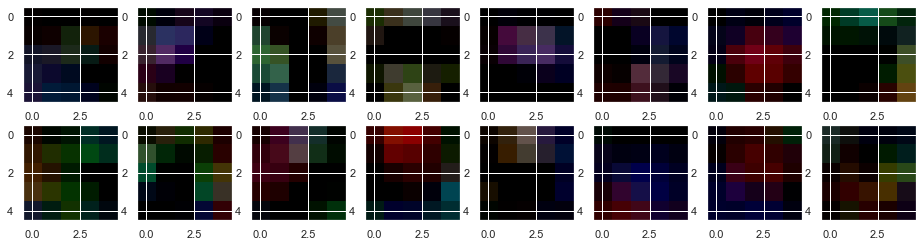

In [51]:
params = list(model.named_parameters())
fig_sub,plots = plt.subplots(2,8,figsize=(16,4))                                 
k = 0
for i in range(2):
    for j in range(8):
        #plt.grid(False)
        w_print = params[0][1][k].cpu().detach().numpy()
        plots[i,j].imshow(np.transpose(w_print, (1, 2, 0))) 
        k = k + 1

***
CHEN Chen a1819099, 26-Oct-2022